In [98]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time


#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

# Import module for data visualization
from plotnine import *
import plotnine

import pickle

%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get all data

In [19]:
# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    coded=True,
)


df = pd.concat([X_train, X_valid])
df['Survival_Group'] = pd.concat([y_train, y_valid])

df = utils.get_decoded_data(df)

cols_to_insert_order = [
    'Diagnosis_Delay',
    'Age_at_Onset',
    'BMI_at_Diagnosis',
    'Q1_Speech_slope_at_Diagnosis',
    'Q2_Salivation_slope_at_Diagnosis',
    'Q3_Swallowing_slope_at_Diagnosis',
    'Q4_Handwriting_slope_at_Diagnosis',
    'Q5_Cutting_slope_at_Diagnosis',
    'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
    'Q7_Turning_in_Bed_slope_at_Diagnosis',
    'Q8_Walking_slope_at_Diagnosis',
    'Q9_Climbing_Stairs_slope_at_Diagnosis',
    'Q10_Respiratory_slope_at_Diagnosis',
]

for col in cols_to_insert_order:
    df[col] = df[col].apply(lambda x: utils.set_feature_values_order(x))

df

,Sex,Site_Onset,Diagnosis_Delay,Age_at_Onset,Riluzole,FVC_at_Diagnosis,BMI_at_Diagnosis,Q1_Speech_slope_at_Diagnosis,Q2_Salivation_slope_at_Diagnosis,Q3_Swallowing_slope_at_Diagnosis,...,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis,Survival_Group
0,Male,Limb/Spinal,(0) Short,50-59,No,Abnormal,(2) Overweight,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(0) Slow,(0) Slow,3,Yes,Yes,Yes,No,No,Non-Short
1,Male,Limb/Spinal,(1) Average,60-69,No,Normal,(2) Overweight,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(1) Average,(0) Slow,3,Yes,Yes,Yes,No,No,Non-Short
2,Male,Limb/Spinal,(0) Short,40-49,No,Abnormal,(1) Normal,(1) Average,(0) Slow,(0) Slow,...,(0) Slow,(1) Average,(0) Slow,3,Yes,Yes,Yes,No,No,Non-Short
3,Female,Bulbar,(1) Average,50-59,No,Abnormal,(3) Obesity,(1) Average,(1) Average,(1) Average,...,(1) Average,(1) Average,(1) Average,3,Yes,No,Yes,Yes,No,Short
4,Male,Bulbar,(2) Long,60-69,No,Normal,(3) Obesity,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(1) Average,(0) Slow,4,Yes,Yes,Yes,Yes,No,Non-Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Male,Limb/Spinal,(0) Short,40-49,No,Abnormal,(1) Normal,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(0) Slow,(0) Slow,3,No,Yes,Yes,Yes,No,Non-Short
390,Female,Limb/Spinal,(2) Long,60-69,No,Abnormal,(3) Obesity,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(1) Average,(0) Slow,1,No,No,Yes,No,No,Non-Short
391,Male,Limb/Spinal,(0) Short,60-69,No,Normal,(1) Normal,(0) Slow,(0) Slow,(0) Slow,...,(1) Average,(1) Average,(0) Slow,1,No,No,Yes,No,No,Non-Short
392,Female,Limb/Spinal,(0) Short,60-69,No,Abnormal,(1) Normal,(0) Slow,(0) Slow,(0) Slow,...,(0) Slow,(0) Slow,(0) Slow,3,No,Yes,Yes,Yes,No,Non-Short


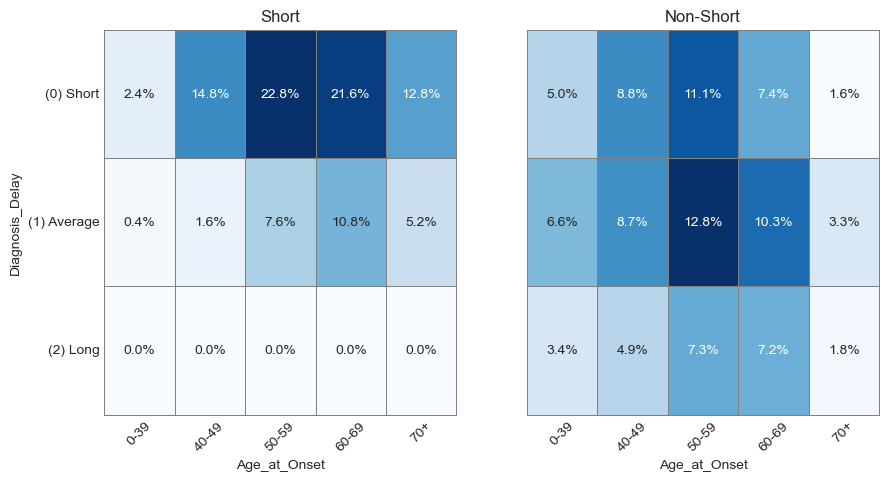

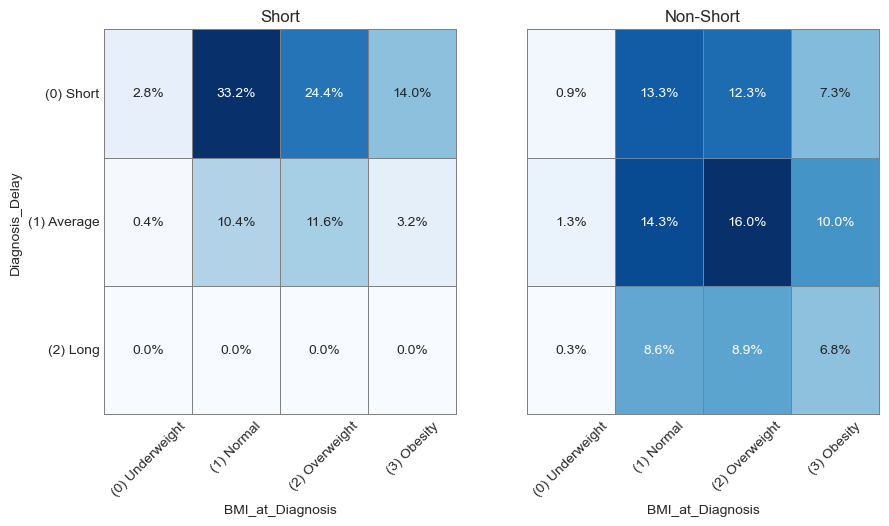

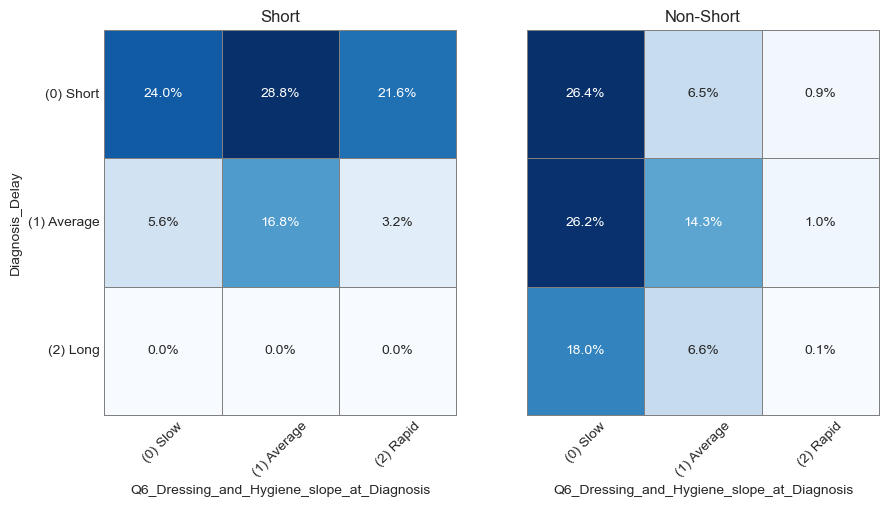

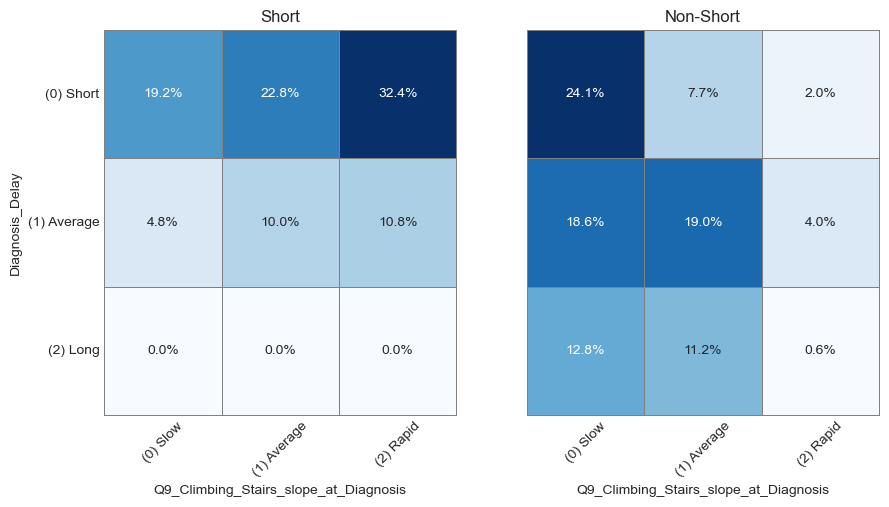

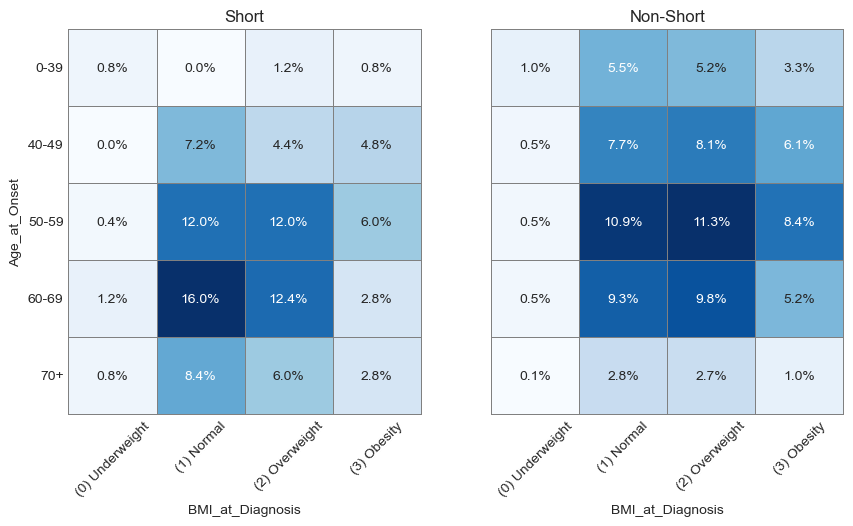

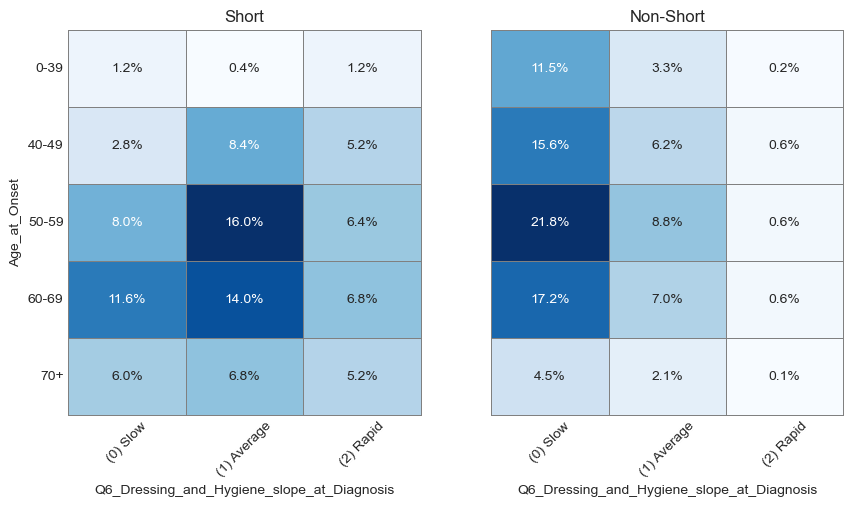

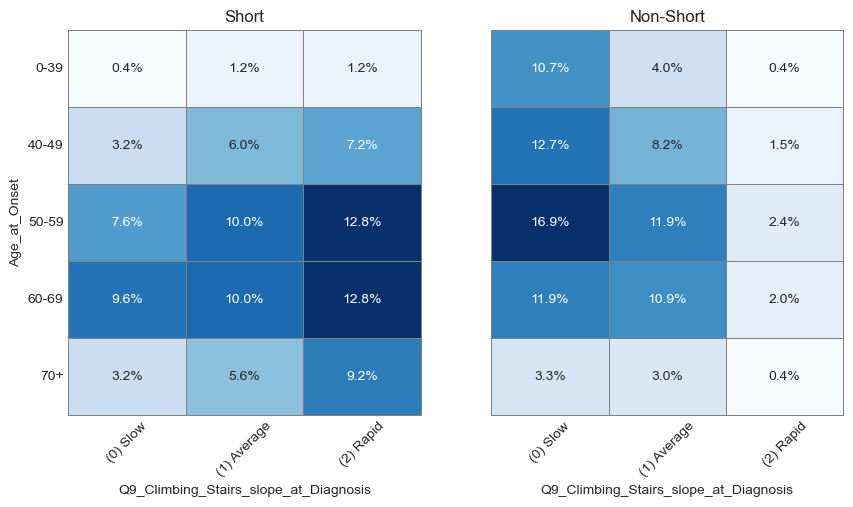

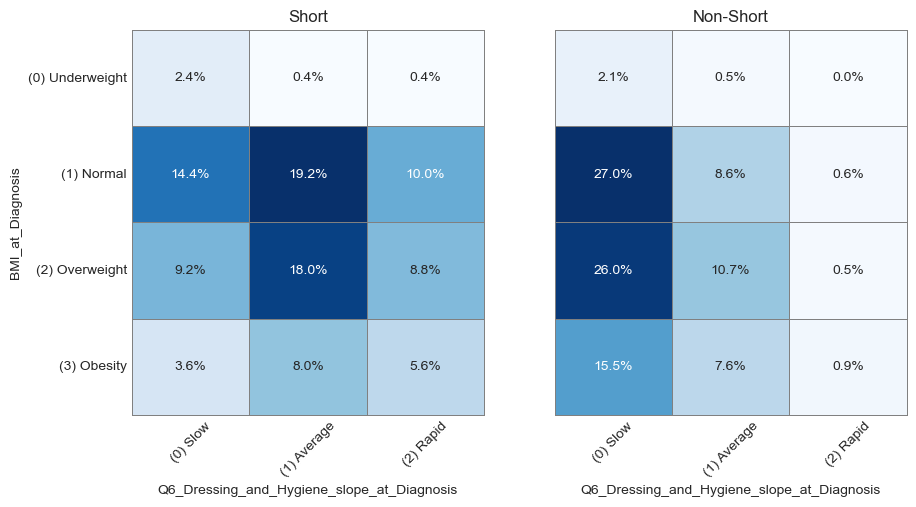

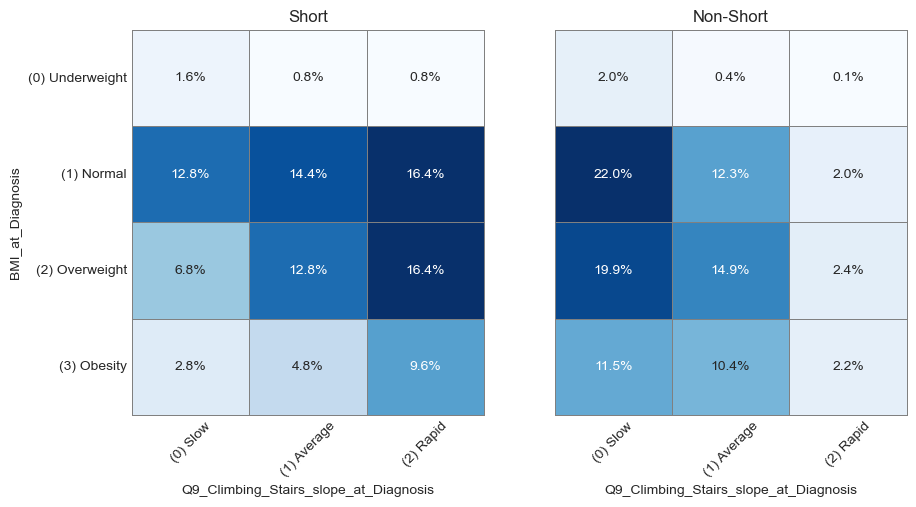

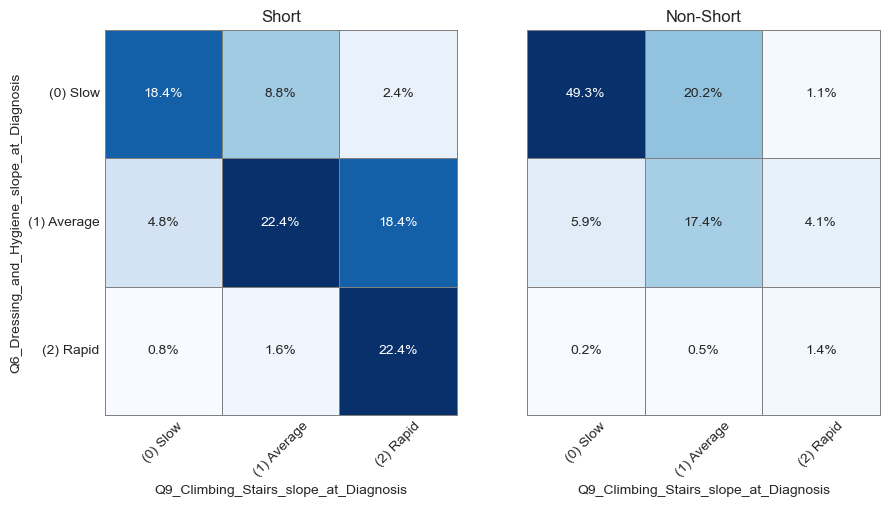

In [165]:
import itertools as it

cols_to_compare = [
    'Diagnosis_Delay',
    'Age_at_Onset',
    'BMI_at_Diagnosis',
#     'Q1_Speech_slope_at_Diagnosis',
#     'Q2_Salivation_slope_at_Diagnosis',
#     'Q3_Swallowing_slope_at_Diagnosis',
#     'Q4_Handwriting_slope_at_Diagnosis',
#     'Q5_Cutting_slope_at_Diagnosis',
    'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
#     'Q7_Turning_in_Bed_slope_at_Diagnosis',
#     'Q8_Walking_slope_at_Diagnosis',
    'Q9_Climbing_Stairs_slope_at_Diagnosis',
#     'Q10_Respiratory_slope_at_Diagnosis',
]

dfs = df.loc[(df.Survival_Group=='Short')].copy()
dfn = df.loc[(df.Survival_Group!='Short')].copy()


for col1, col2 in it.combinations(cols_to_compare, 2):
    
    ctab = pd.crosstab(
        index=df[col1],
        columns=[ df.Survival_Group ,df[col2]],
    )
    
    fig, axs = plt.subplots(1,2, figsize=[10,5], sharex=True, sharey=True)
    
    i = 0
    for grp in ['Short', 'Non-Short']:

        ctab_aux = ctab[grp]
        tot = np.sum(ctab_aux.values)
#         print(tot)
        
        sns.heatmap(
            ctab_aux/tot, 
            annot=True,
            fmt='.1%',
            cmap='Blues',
            cbar=False,
            ax=axs[i],
            linecolor='gray',
            linewidths=0.5,
            clip_on=False,
        )
        axs[i].set_title('Short' if i==0 else'Non-Short')
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].tick_params(axis='y', rotation=0)
        axs[i].set_ylabel(col1 if i==0 else '')

        i += 1
    plt.show()
        
#     break

In [116]:
tt = pd.crosstab(
    index=df[col1],
    columns=[ df.Survival_Group ,df[col2]],
)

display(tt)

tt['Non-Short']

Survival_Group                             Non-Short                        \
Q6_Dressing_and_Hygiene_slope_at_Diagnosis  (0) Slow (1) Average (2) Rapid   
Diagnosis_Delay                                                              
(0) Short                                        453         111        16   
(1) Average                                      450         246        18   
(2) Long                                         309         113         1   

Survival_Group                                Short                        
Q6_Dressing_and_Hygiene_slope_at_Diagnosis (0) Slow (1) Average (2) Rapid  
Diagnosis_Delay                                                            
(0) Short                                        60          72        54  
(1) Average                                      14          42         8  
(2) Long                                          0           0         0

Q6_Dressing_and_Hygiene_slope_at_Diagnosis,(0) Slow,(1) Average,(2) Rapid
Diagnosis_Delay,,,
(0) Short,453,111,16
(1) Average,450,246,18
(2) Long,309,113,1


# Create contigency tables between features

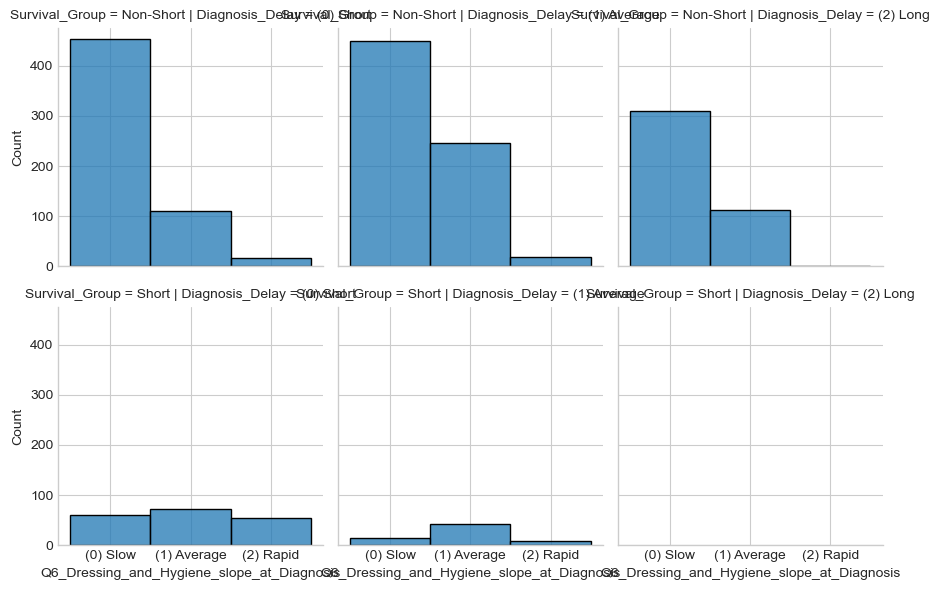

In [55]:
g = sns.FacetGrid(
    df, 
    col="Diagnosis_Delay", 
    row="Survival_Group"
)
g.map(sns.histplot, "Q6_Dressing_and_Hygiene_slope_at_Diagnosis")


Diagnosis_Delay,(0) Short,(1) Average,(2) Long
Q6_Dressing_and_Hygiene_slope_at_Diagnosis,,,
(0) Slow,513,464,309
(1) Average,183,288,113
(2) Rapid,70,26,1


<Axes: xlabel='Q6_Dressing_and_Hygiene_slope_at_Diagnosis'>

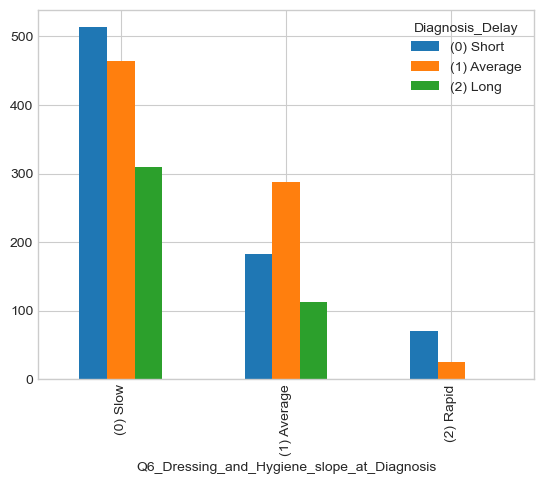

In [57]:
tab = pd.crosstab(
    index=df.Q6_Dressing_and_Hygiene_slope_at_Diagnosis,
    columns=[
#         df.Survival_Group, 
        df.Diagnosis_Delay
    ],
#     margins=True,
)

display(tab)


# sns.countplot(
#     data=df, 
#     x="Q6_Dressing_and_Hygiene_slope_at_Diagnosis", 
# #     y="Diagnosis_Delay", 
#     hue="Survival_Group",
# #     kind="bar", height=4, aspect=.6,
# )
# plt.show()

# sns.relplot(
#     data=df,
#     x="Q6_Dressing_and_Hygiene_slope_at_Diagnosis", 
#     y="Diagnosis_Delay", 
# #     hue="day", 
#     hue="Survival_Group",
# )
# plt.show()
 

tab.plot(kind='bar')

In [72]:
tab/1967*100

Diagnosis_Delay,(0) Short,(1) Average,(2) Long
Q6_Dressing_and_Hygiene_slope_at_Diagnosis,,,
(0) Slow,23.029995,22.877478,15.709202
(1) Average,5.643111,12.506355,5.744789
(2) Rapid,0.813421,0.915099,0.050839
